In [1]:
#for more advanced hisfile operations: https://github.com/Deltares/dfm_tools/blob/main/tests/examples/postprocess_hisnc.py
#for more advanced mapfile operations: https://github.com/Deltares/dfm_tools/blob/main/tests/examples/postprocess_mapnc_ugrid.py
import os
os.chdir('..') #necessary to go one level up to the root directory to find dfm_tools in notebook/binder
import xarray as xr
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import dfm_tools as dfmt


In [2]:
#set paths and parameters per model (change 'model' parameters to get different results/plots)
#in this notebook, file_nc_map has to be a list since opendap does not support glob/wildcards
#if you use a local/network file instead, you can use something like 'Grevelingen-FM_0*_map.nc' instead
model = 'grevelingen' #'curvedbend' 'grevelingen' 'westernscheldt'

dir_opendap = 'http://opendap.deltares.nl/thredds/dodsC/opendap/deltares/Delft3D/netcdf_example_files'
if model=='curvedbend':
    file_nc_his = dir_opendap + '/DFM_curvedbend_3D/cb_3d_his.nc'
    file_nc_map = [dir_opendap + '/DFM_curvedbend_3D/cb_3d_map.nc']
    rename_mapvars = {}
    layer = 5
    crs = None
    line_array = np.array([[ 104.15421399, 2042.7077107 ],
                           [2913.47878063, 2102.48057382]])
elif model=='grevelingen':
    file_nc_his = dir_opendap + '/DFM_grevelingen_3D/Grevelingen-FM_0000_his.nc'
    file_nc_map = [dir_opendap + f'/DFM_grevelingen_3D/Grevelingen-FM_{i:04d}_map.nc' for i in range(8)]
    rename_mapvars = {}
    layer = 34
    crs = 'EPSG:28992'
    line_array = np.array([[ 53181.96942503, 424270.83361629],
                           [ 55160.15232593, 416913.77136685]])
elif model=='westernscheldt':
    file_nc_his = None
    file_nc_map = [dir_opendap + '/westernscheldt_sph_map.nc']
    rename_mapvars = {'mesh2d_FlowElem_bl':'mesh2d_flowelem_bl'}
    layer = None
    crs = 'EPSG:4326'
    line_array = None
else:
    raise Exception(f'undefined model: {model}')


In [3]:
#open hisfile with xarray and print netcdf structure
if file_nc_his is not None:
    data_xr_his = xr.open_mfdataset([file_nc_his], preprocess=dfmt.preprocess_hisnc)
    print(data_xr_his)
    stations_pd = data_xr_his['stations'].to_dataframe()
    print('\nStations in netcdf dataset:\n',stations_pd[['station_x_coordinate','station_y_coordinate']])


dropping 45 duplicate "source_sink_name" labels to avoid InvalidIndexError
<xarray.Dataset>
Dimensions:                                       (stations: 24, time: 145,
                                                   laydim: 36, laydimw: 37,
                                                   source_sink_pts: 2,
                                                   source_sink: 1)
Coordinates:
    station_x_coordinate                          (stations) float64 4.747e+0...
    station_y_coordinate                          (stations) float64 4.188e+0...
    zcoordinate_c                                 (time, stations, laydim) float64 dask.array<chunksize=(145, 24, 36), meta=np.ndarray>
    zcoordinate_w                                 (time, stations, laydimw) float64 dask.array<chunksize=(145, 24, 37), meta=np.ndarray>
  * time                                          (time) datetime64[ns] 2007-...
  * stations                                      (stations) <U25 'GTSO-01' ....
  * sour

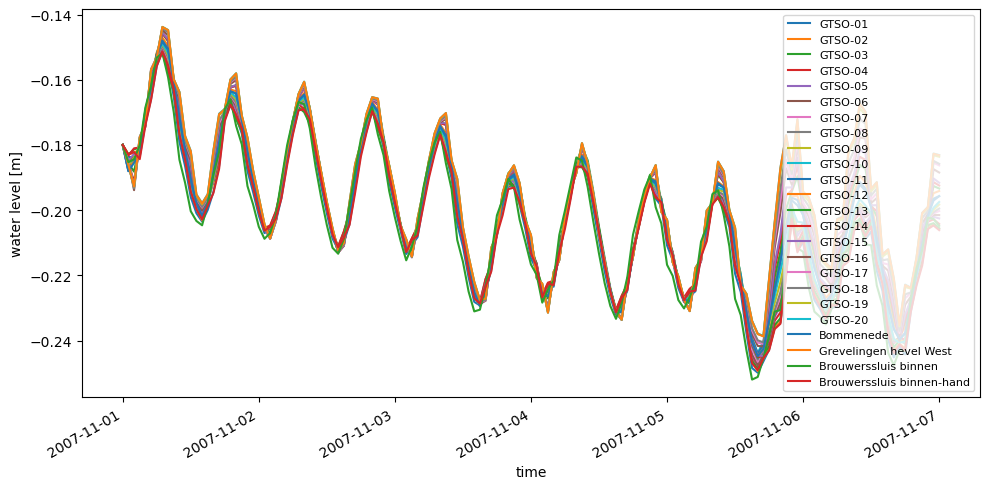

In [4]:
#plot his data: waterlevel at stations
if file_nc_his is not None:
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    data_xr_his.waterlevel.plot.line(ax=ax, x='time')
    ax.legend(data_xr_his.stations.to_series(),loc=1,fontsize=8) #optional, to change legend location
    fig.tight_layout()


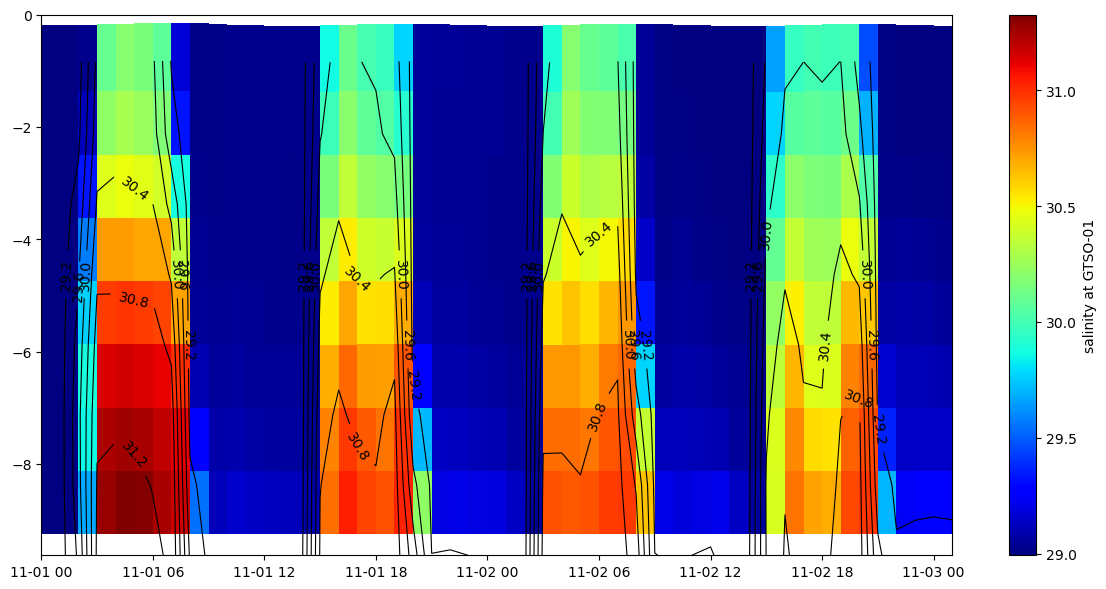

In [5]:
#plot his data: temperature zt at one station
if file_nc_his is not None:
    data_xr_selzt = data_xr_his.isel(stations=0).isel(time=slice(0,50))
    fig, ax1 = plt.subplots(figsize=(12,6))
    c = dfmt.plot_ztdata(data_xr_sel=data_xr_selzt, varname='salinity', ax=ax1, cmap='jet')
    fig.colorbar(c,ax=ax1,label=f'salinity at {data_xr_selzt.stations.data}')
    CS = dfmt.plot_ztdata(data_xr_sel=data_xr_selzt, varname='salinity', ax=ax1, only_contour=True, levels=6, colors='k', linewidths=0.8, linestyles='solid')
    ax1.clabel(CS, fontsize=10)
    fig.tight_layout()

In [6]:
#open+merge mapfile with xugrid(xarray) and print netcdf structure
data_xr_mapmerged = dfmt.open_partitioned_dataset(file_nc_map)
data_xr_mapmerged = data_xr_mapmerged.rename(rename_mapvars)
print(data_xr_mapmerged)


>> xu.open_dataset() with 8 partition(s): 0.98 sec
>> ds.isel()/xr.append(): 0.25 sec
>> xr.concat(): 0.08 sec
10    mesh2d_face_x_bnd
11    mesh2d_face_y_bnd
dtype: object
>> open_partitioned_dataset total: 1.45 sec
<xarray.Dataset>
Dimensions:                      (mesh2d_nFaces: 44796, time: 4,
                                  nmesh2d_layer: 36, mesh2d_nNodes: 26779,
                                  mesh2d_nEdges: 77761, Two: 2,
                                  nmesh2d_interface: 37)
Coordinates:
    mesh2d_face_x                (mesh2d_nFaces) float64 dask.array<chunksize=(5599,), meta=np.ndarray>
    mesh2d_face_y                (mesh2d_nFaces) float64 dask.array<chunksize=(5599,), meta=np.ndarray>
  * time                         (time) datetime64[ns] 2007-11-01 ... 2007-11-07
    mesh2d_node_x                (mesh2d_nNodes) float64 dask.array<chunksize=(3454,), meta=np.ndarray>
    mesh2d_node_y                (mesh2d_nNodes) float64 dask.array<chunksize=(3454,), meta=np.ndar

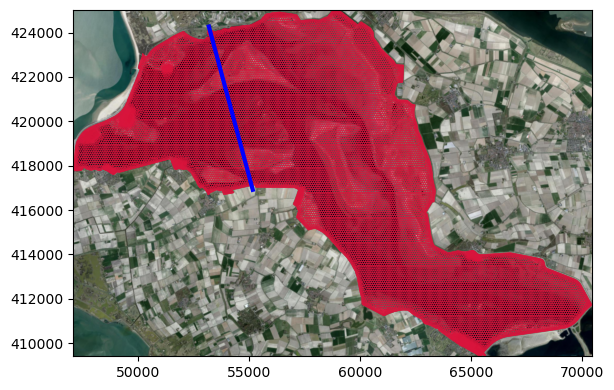

In [7]:
#plot net/grid. use random variable and plot line to get grid
fig, ax = plt.subplots(figsize=(10,4))
pc = data_xr_mapmerged.ugrid.grid.plot(edgecolor='crimson', linewidth=0.5)
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
if line_array is not None:
    ax.plot(line_array[:,0],line_array[:,1],'b',linewidth=3)
fig.tight_layout()


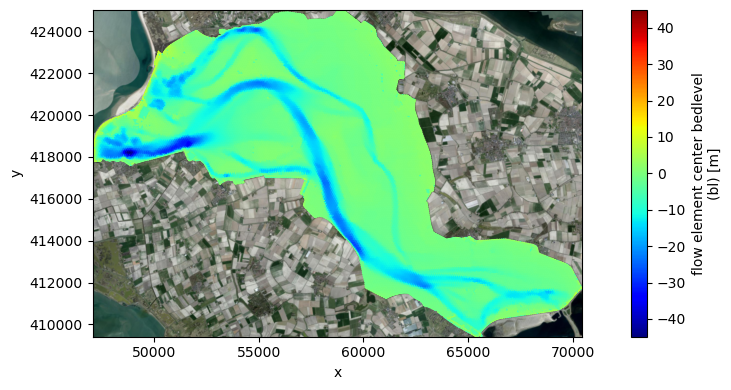

In [8]:
#plot bedlevel on map
fig, ax = plt.subplots(figsize=(10,4))
pc = data_xr_mapmerged['mesh2d_flowelem_bl'].ugrid.plot(edgecolor='face',cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
fig.tight_layout()


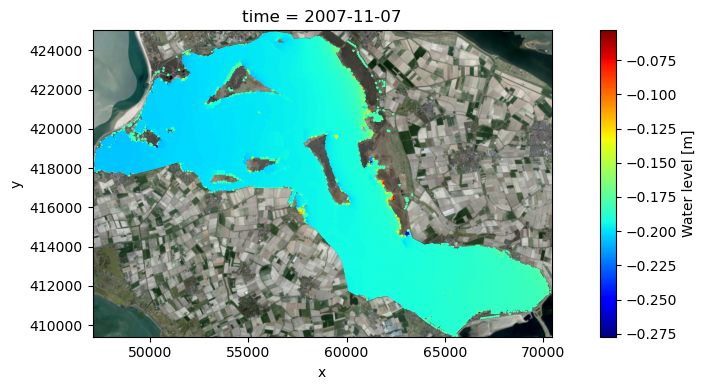

In [9]:
#filter dry cells
bool_drycells = data_xr_mapmerged['mesh2d_s1']==data_xr_mapmerged['mesh2d_flowelem_bl']
data_xr_mapmerged['mesh2d_s1_filt'] = data_xr_mapmerged['mesh2d_s1'].where(~bool_drycells)

#plot water level on map
fig, ax = plt.subplots(figsize=(10,4))
pc = data_xr_mapmerged['mesh2d_s1_filt'].isel(time=3).ugrid.plot(edgecolor='face',cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
fig.tight_layout()


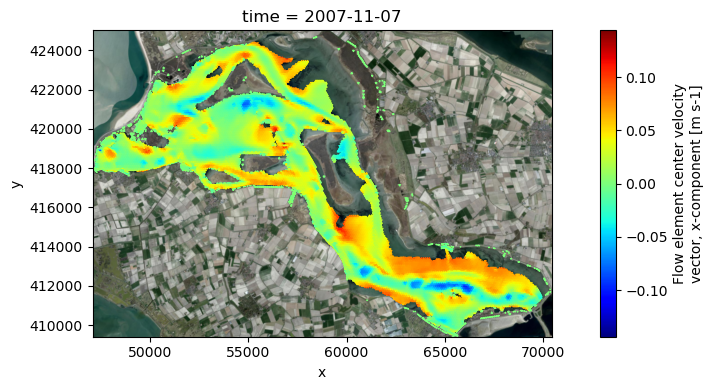

In [10]:
#plot eastward velocities on map
fig, ax = plt.subplots(figsize=(10,4))
if layer is None:
    pc = data_xr_mapmerged['mesh2d_ucx'].isel(time=3).ugrid.plot(edgecolor='face',cmap='jet')
else:
    pc = data_xr_mapmerged['mesh2d_ucx'].isel(time=3,nmesh2d_layer=layer).ugrid.plot(edgecolor='face',cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
fig.tight_layout()

defining celinlinebox
finding crossing flow links (can take a while if linebox over xy covers a lot of cells, 3809 of 44796 cells are being processed)
calculating distance for all crossed cells, from first point of line (should not take long, but if it does, optimisation is needed)
finished calculating distance for all crossed cells, from first point of line
done finding crossing flow links: 169 of 44796
layertype: zlayer


c:\DATA\dfm_tools\dfm_tools\get_nc.py:535: UserWarning: WARNING: your model seems to contain only z-layers. if the modeloutput is generated with an older version of dflowfm, the coordinates can be incorrect. if your model contains z-sigma-layers, use the fulloutput option in the mdu and rerun (happens automatically in newer dflowfm versions).
  warnings.warn('WARNING: your model seems to contain only z-layers. if the modeloutput is generated with an older version of dflowfm, the coordinates can be incorrect. if your model contains z-sigma-layers, use the fulloutput option in the mdu and rerun (happens automatically in newer dflowfm versions).')


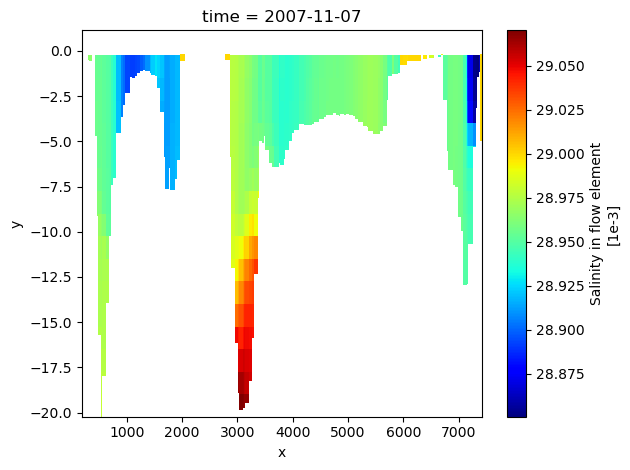

In [11]:
#plot slice/sideview trough 3D salinity mapdata
if line_array is not None:
    xr_crs_ugrid = dfmt.polyline_mapslice(data_xr_mapmerged, line_array, timestep=3)
    fig, ax = plt.subplots()
    xr_crs_ugrid['mesh2d_sa1'].ugrid.plot(cmap='jet')
    fig.tight_layout()
